In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

## Multi-armed Bandits Algorithm

In this notebook, you will be testing the naive multi-armed bandit algorithm on a 10-armed testbed (Section 2.3, pg. 28).

In [46]:
class Bandit:
    def __init__(self, k_arms=10, q_true=None):
        self.k_arms = k_arms
        self.q_true = np.random.randn(self.k_arms) if q_true is None else q_true
        self.best_action = np.argmax(self.q_true)

    def reset(self):
        """Reset the environment"""
        self.q_true = np.random.randn(self.k_arms)
        self.best_action = np.argmax(self.q_true)

    def step(self, action: int):
        """Take an action in the bandit environment: pull the n-th lever"""
        return self.q_true[action] + np.random.randn(), (action == self.best_action)
    
    def plot_reward_distribution(self):
        """Figure 2.1 on Page 28"""
        plt.violinplot(dataset=self.q_true + np.random.randn(200, 10))
        plt.xlabel("Action")
        plt.ylabel("Reward distribution")
        plt.show()


class BanditAgent:
    def __init__(self, epsilon=0.01, k_arms=10, gradient=False):
        self.epsilon = epsilon
        self.k_arms = k_arms
        self.q_func = np.zeros(k_arms)
        self.action_cnt = np.zeros(k_arms)
        self.gradient = gradient

        self.action_space = np.arange(k_arms)

    def reset(self):
        """Reset the agent"""
        self.q_func = np.zeros(self.k_arms)
        self.action_cnt = np.zeros(self.k_arms)

    def act(self):
        """Sample an action based on the current action-value function and epsilon-greediness"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        # TODO: gradient algorithm (if self.gradient then do sampling from a action distribution)
        else:
            q_best = np.max(self.q_func)
            return np.random.choice(np.where(self.q_func == q_best)[0]) # break tie if happens
        
    def _update(self, action, reward):
        """Single updating iteration for the q estimation"""
        self.q_func[action] +=  (reward - self.q_func[action]) / self.action_cnt[action]
        # TODO: gradient algorithm 

    
    def learn(self, env: Bandit, n_iter):
        """Learning loop"""
        reward_arr = np.zeros(n_iter)
        best_action_arr = np.zeros(n_iter)

        for t in range(n_iter):
            action = self.act()
            self.action_cnt[action] += 1

            reward, is_best_action = env.step(action)
            reward_arr[t] = reward

            self._update(action, reward)

            if is_best_action:
                best_action_arr[t] = 1
        return reward_arr, best_action_arr

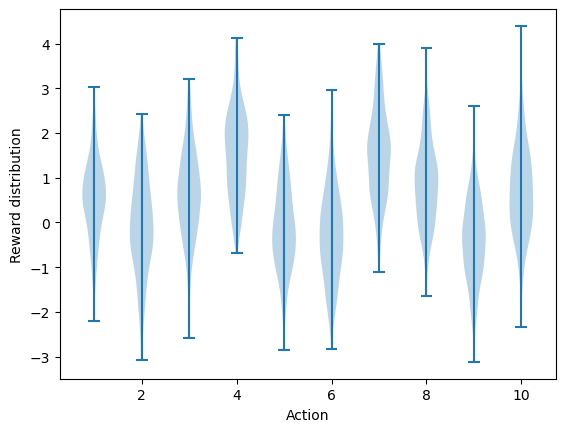

In [57]:
# Set up
np.random.seed(42)

k_arms = 10
n_run = 1000
n_iter = 1000

bandit = Bandit(k_arms=k_arms)

bandit.plot_reward_distribution()

In [58]:
# Epsilon-greedy experiment

eps_space = [0, 0.1, 0.001]

reward_matrix = np.zeros((len(eps_space), n_run, n_iter))
best_action_matrix = np.zeros(reward_matrix.shape)

for i, eps in enumerate(eps_space):
    agent = BanditAgent(epsilon=eps, k_arms=k_arms)
    for j in trange(n_run):
        bandit.reset()
        agent.reset()
        reward_matrix[i, j], best_action_matrix[i, j] = agent.learn(bandit, n_iter=n_iter)

100%|██████████| 1000/1000 [00:25<00:00, 38.57it/s]


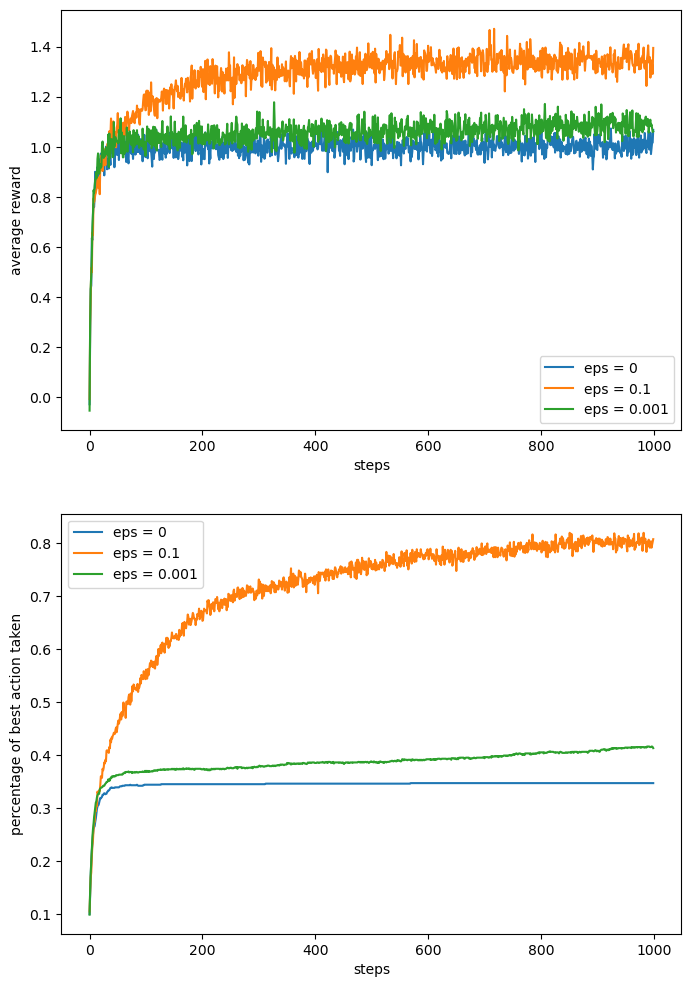

In [59]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
for eps, reward_matrix_for_this_eps in zip(eps_space, reward_matrix):
    plt.plot(reward_matrix_for_this_eps.mean(axis=0), label=f"eps = {eps}")
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, best_action_matrix_for_this_eps in zip(eps_space, best_action_matrix):
    plt.plot(best_action_matrix_for_this_eps.mean(axis=0), label=f"eps = {eps}")
plt.xlabel('steps')
plt.ylabel('percentage of best action taken')
plt.legend()